In [80]:
from psycopg2 import connect
import configparser
%matplotlib inline
import numpy as np
import pandas as pd
import pandas.io.sql as pandasql
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

CONFIG = configparser.ConfigParser()
CONFIG.read('db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

from IPython.display import HTML

def print_table(sql, con):
    return HTML(pandasql.read_sql(sql, con).to_html(index=False))

## Validating the GTFS stops and CIS data in directions

### Comparing the the frequency of stop sequences of GTFS data in hours 6-25 and CIS data in hours 0-23

There are four heat maps outputted, which indicate the distributions of GTFS data and CIS data of each stop_sequence in hours in different directions.

In [2]:
sql_GTFS_1 = '''
SELECT EXTRACT(hour from arrival_time) AS hours, stop_sequence, count(*) AS schedule FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND direction_id = 1 AND shape_id = 691042
GROUP BY hours, stop_sequence
ORDER BY hours, stop_sequence
'''

df1 = pandasql.read_sql(sql_GTFS_1, con)

df1 = df1.pivot("hours", "stop_sequence", "schedule")

In [3]:
sql_GTFS_0 = '''
SELECT EXTRACT(hour from arrival_time) AS hours, stop_sequence, count(*) AS schedule FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND direction_id = 0 AND shape_id = 691040 
GROUP BY hours, stop_sequence
ORDER BY hours, stop_sequence
'''

df2 = pandasql.read_sql(sql_GTFS_0, con)

df2 = df2.pivot("hours", "stop_sequence", "schedule")

In [4]:
sql_cis_1 = '''
WITH CIS AS (SELECT EXTRACT(hour from date_time) AS hours, stop_id, count(*) AS cis_data FROM dzou2.dd_cis_514_angle
WHERE direction_id = 1
GROUP BY hours, stop_id
ORDER BY hours, stop_id
),

new_stop_times AS (
SELECT DISTINCT ON(stop_id, stop_sequence) stop_id, stop_sequence
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND shape_id = 691042
)

SELECT hours, stop_sequence, sum(cis_data) AS cis_data
FROM CIS
INNER JOIN new_stop_times USING (stop_id)
GROUP BY hours, stop_sequence
'''

df3 = pandasql.read_sql(sql_cis_1, con)

df3 = df3.pivot("hours", "stop_sequence", "cis_data")

In [5]:
sql_cis_0 = '''
WITH CIS AS (SELECT EXTRACT(hour from date_time) AS hours, stop_id, count(*) AS cis_data FROM dzou2.dd_cis_514_angle
WHERE direction_id = 0
GROUP BY hours, stop_id
ORDER BY hours, stop_id
),

new_stop_times AS (
SELECT DISTINCT ON(stop_id, stop_sequence) stop_id, stop_sequence
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND shape_id = 691040
)

SELECT hours, stop_sequence, sum(cis_data) AS cis_data
FROM CIS
INNER JOIN new_stop_times USING (stop_id)
GROUP BY hours, stop_sequence
'''

df4 = pandasql.read_sql(sql_cis_0, con)

df4 = df4.pivot("hours", "stop_sequence", "cis_data")

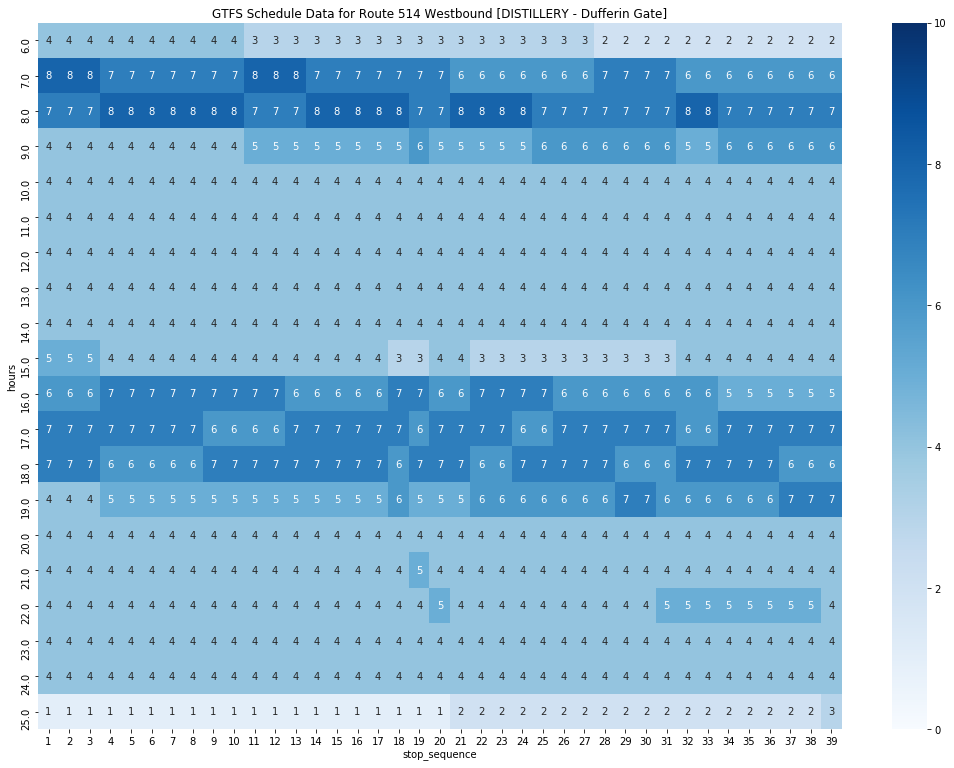

In [9]:
plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('GTFS Schedule Data for Route 514 Westbound [DISTILLERY - Dufferin Gate]')
sns.heatmap(df1, vmin = 0, vmax = 10, cmap = 'Blues', annot=True, fmt='g')

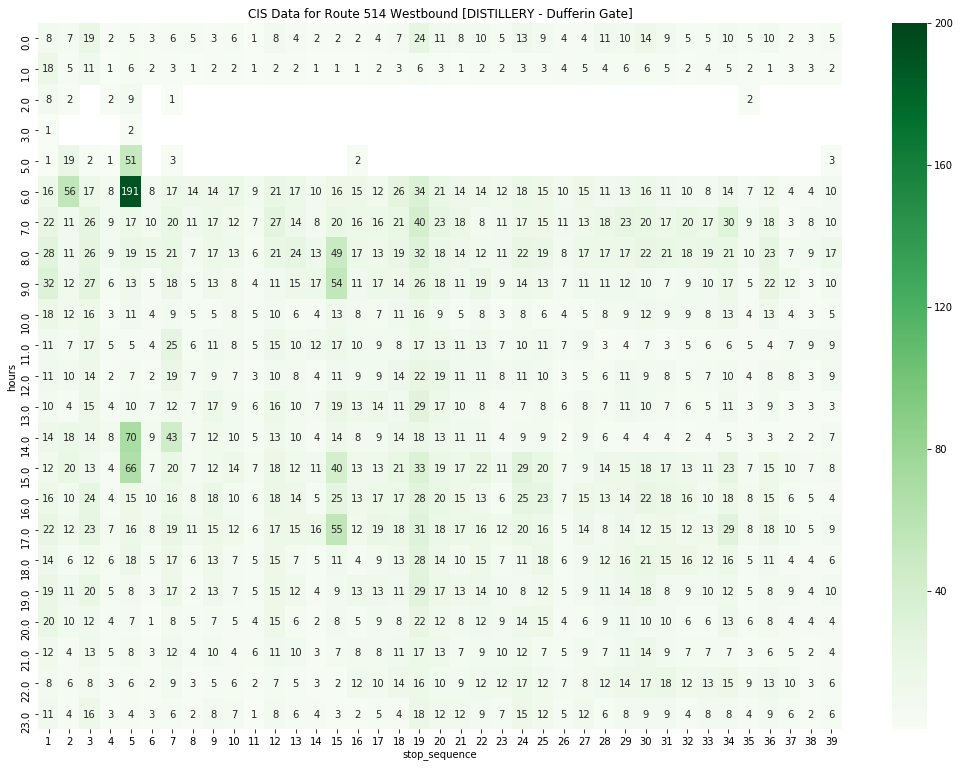

In [10]:
plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('CIS Data for Route 514 Westbound [DISTILLERY - Dufferin Gate]')
sns.heatmap(df3, vmin=1, vmax=200,cmap = 'Greens', annot=True, fmt='g')

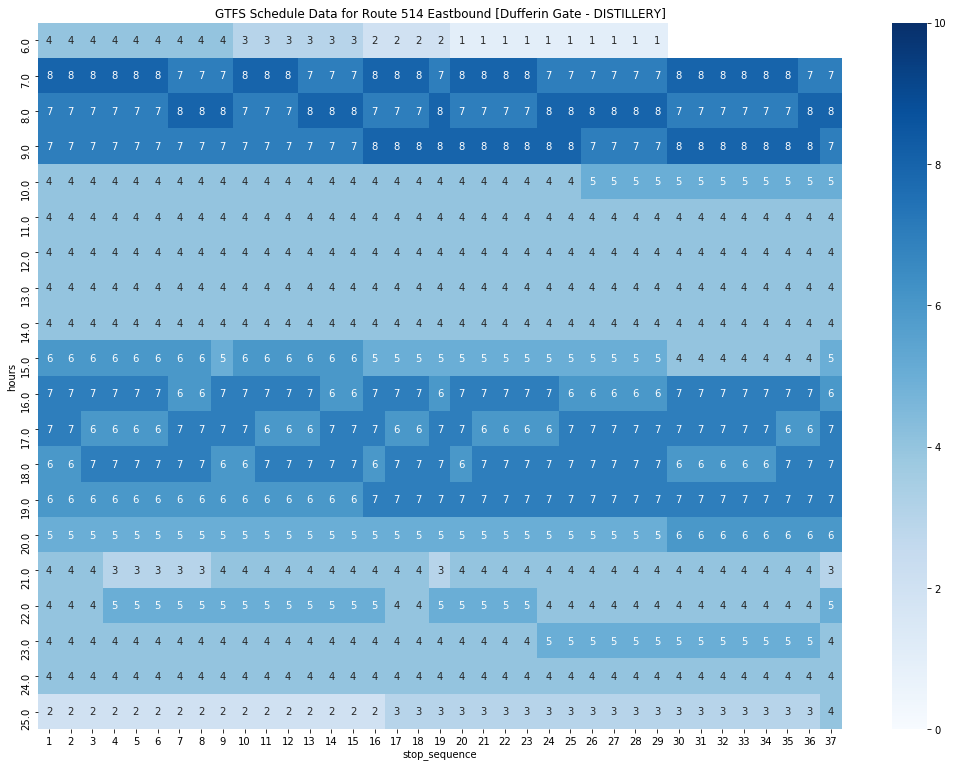

In [11]:
plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('GTFS Schedule Data for Route 514 Eastbound [Dufferin Gate - DISTILLERY]')
sns.heatmap(df2, vmin = 0, vmax = 10, cmap = 'Blues', annot=True, fmt='g')

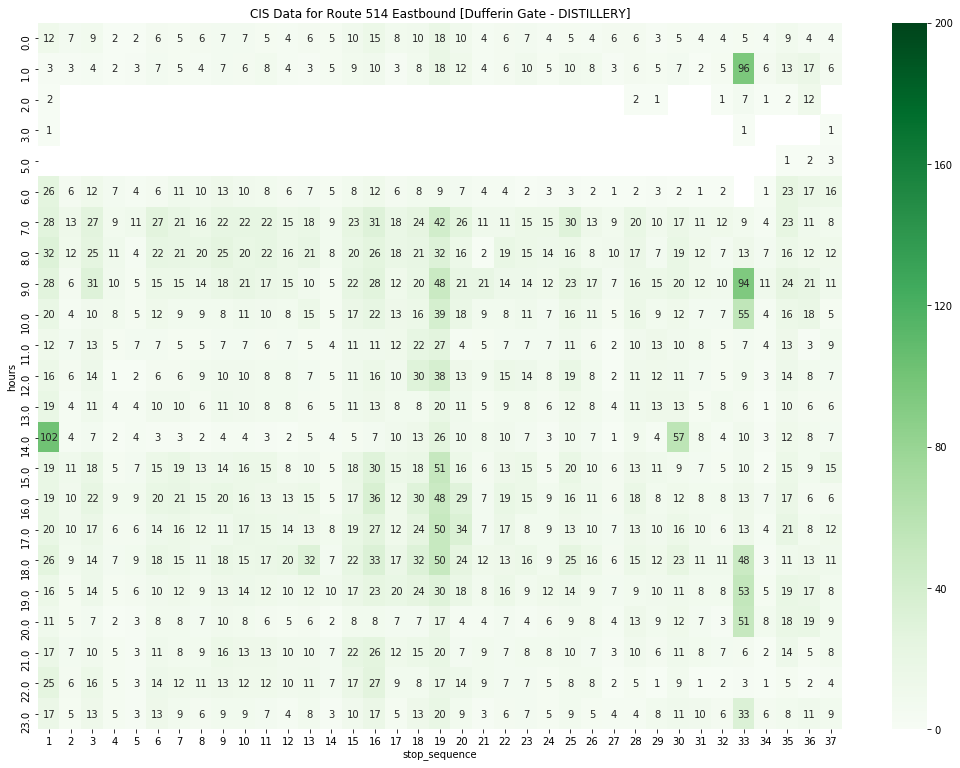

In [13]:
plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('CIS Data for Route 514 Eastbound [Dufferin Gate - DISTILLERY]')
sns.heatmap(df4, vmin=0, vmax=200,cmap = 'Greens', annot=True, fmt='g')

### Validating and Comparing the numbers of GTFS data and CIS data in different stop sequences in a day.

#### The heat maps represent the difference between the count of GTFS schedule service and the count of CIS data with the same stop sequence in hours in the direction of 0 and 1.

The `time interval` is a key parameter to determine the frequency of CIS data, and we choose 3700 as the final time interval value. There are the comparison of heat map as the results between `time interval = 300` and `time interval = 3700`.

`time interval = 300` means the time interval is 5 minutes.
`time interval = 3700` means the time interval is 1 hour 1 minute 40 seconds.

In [6]:
sql_300 = '''
WITH line_data AS(
SELECT geom AS line, direction_id FROM gtfs_raph.shapes_geom_20171004
    INNER JOIN gtfs_raph.trips_20171004 USING (shape_id)
    WHERE shape_id IN (691040, 691042)
    GROUP BY line, shape_id, direction_id
    ORDER BY shape_id
),

cis_gtfs AS(
SELECT date_time, id AS cis_id, stop_id, a.direction_id,
ST_LineLocatePoint(line, position) AS cis_to_line, vehicle,
ST_LineLocatePoint(line, geom) AS stop_to_line,
(CASE WHEN ST_LineLocatePoint(line, position) > ST_LineLocatePoint(line, geom)
      THEN 'after'
      WHEN ST_LineLocatePoint(line, position) < ST_LineLocatePoint(line, geom)
      THEN 'before'
      WHEN ST_LineLocatePoint(line, position) = ST_LineLocatePoint(line, geom)
      THEN 'same'
      END) AS line_position,
ST_Distance(position::geography, geom::geography) AS distance
FROM line_data a, dzou2.dd_cis_514_angle b
INNER JOIN gtfs_raph.stops_20171004 USING (stop_id)
WHERE a.direction_id = b.direction_id
ORDER BY direction_id, date_time),

match_stop AS(
SELECT MIN(date_time) AS arrival_time, MAX(date_time) AS departure_time, vehicle, stop_id, direction_id
FROM cis_gtfs
WHERE (line_position = 'before' AND distance <= 200) OR (line_position = 'after' AND distance <= 10)
      OR (line_position = 'same' AND distance <= 100)
GROUP BY vehicle, stop_id, direction_id, (floor((extract('epoch' from date_time)-1) / 300) * 300)
ORDER BY arrival_time, direction_id
),

gtfs_data AS (
SELECT (CASE WHEN EXTRACT(HOUR FROM arrival_time)<= 23
         THEN EXTRACT(HOUR FROM arrival_time)
         WHEN EXTRACT(HOUR FROM arrival_time) = 24
         THEN 0
         WHEN EXTRACT(HOUR FROM arrival_time) = 25
         THEN 1
         END) AS hours,
         stop_id, count(*) AS GTFS_count, direction_id
FROM gtfs_raph.stop_times_20171004_504_514 
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514'
GROUP BY hours, stop_id, direction_id
ORDER BY hours
),

cis_data AS (
SELECT EXTRACT(HOUR FROM arrival_time) as hours, stop_id, count(*) AS cis_count, direction_id
FROM match_stop
GROUP BY hours, stop_id, direction_id
ORDER BY hours
),

new_stop_times AS (
SELECT DISTINCT ON(stop_id, stop_sequence) stop_id, stop_sequence, direction_id, shape_id
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND shape_id IN (691040, 691042)
),

new_cis_data AS (
SELECT hours, stop_sequence, sum(cis_count) AS cis_count, d.direction_id
FROM cis_data d
INNER JOIN new_stop_times USING (stop_id, direction_id)
GROUP BY hours, stop_sequence, d.direction_id
),

new_gtfs_data AS (
SELECT hours, stop_sequence, sum(GTFS_count) AS gtfs_count, e.direction_id
FROM gtfs_data e
INNER JOIN new_stop_times USING (stop_id, direction_id)
GROUP BY hours, stop_sequence, e.direction_id
)

SELECT COALESCE(a.hours, b.hours)AS time_hours, COALESCE(a.stop_sequence, b.stop_sequence) AS stop_sequences,
COALESCE(a.direction_id, b.direction_id) AS direction_ids,
(CASE WHEN gtfs_count IS NULL THEN 0 ELSE gtfs_count END) - (CASE WHEN cis_count IS NULL THEN 0 ELSE cis_count END) AS diff
FROM new_gtfs_data a 
FULL JOIN new_cis_data b ON (a.hours = b.hours) AND (a.stop_sequence = b.stop_sequence) AND (a.direction_id = b.direction_id)
GROUP BY time_hours, stop_sequences, gtfs_count, cis_count, diff, direction_ids
ORDER BY time_hours, stop_sequences, direction_ids
'''

df_300 = pandasql.read_sql(sql_300, con)

In [7]:
sql_3700 = '''
WITH line_data AS(
SELECT geom AS line, direction_id FROM gtfs_raph.shapes_geom_20171004
    INNER JOIN gtfs_raph.trips_20171004 USING (shape_id)
    WHERE shape_id IN (691040, 691042)
    GROUP BY line, shape_id, direction_id
    ORDER BY shape_id
),

cis_gtfs AS(
SELECT date_time, id AS cis_id, stop_id, a.direction_id,
ST_LineLocatePoint(line, position) AS cis_to_line, vehicle,
ST_LineLocatePoint(line, geom) AS stop_to_line,
(CASE WHEN ST_LineLocatePoint(line, position) > ST_LineLocatePoint(line, geom)
      THEN 'after'
      WHEN ST_LineLocatePoint(line, position) < ST_LineLocatePoint(line, geom)
      THEN 'before'
      WHEN ST_LineLocatePoint(line, position) = ST_LineLocatePoint(line, geom)
      THEN 'same'
      END) AS line_position,
ST_Distance(position::geography, geom::geography) AS distance
FROM line_data a, dzou2.dd_cis_514_angle b
INNER JOIN gtfs_raph.stops_20171004 USING (stop_id)
WHERE a.direction_id = b.direction_id
ORDER BY direction_id, date_time),

match_stop AS(
SELECT MIN(date_time) AS arrival_time, MAX(date_time) AS departure_time, vehicle, stop_id, direction_id
FROM cis_gtfs
WHERE (line_position = 'before' AND distance <= 200) OR (line_position = 'after' AND distance <= 10)
      OR (line_position = 'same' AND distance <= 100)
GROUP BY vehicle, stop_id, direction_id, (floor((extract('epoch' from date_time)-1) / 3700) * 3700)
ORDER BY arrival_time, direction_id
),

gtfs_data AS (
SELECT (CASE WHEN EXTRACT(HOUR FROM arrival_time)<= 23
         THEN EXTRACT(HOUR FROM arrival_time)
         WHEN EXTRACT(HOUR FROM arrival_time) = 24
         THEN 0
         WHEN EXTRACT(HOUR FROM arrival_time) = 25
         THEN 1
         END) AS hours,
         stop_id, count(*) AS GTFS_count, direction_id
FROM gtfs_raph.stop_times_20171004_504_514 
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514'
GROUP BY hours, stop_id, direction_id
ORDER BY hours
),

cis_data AS (
SELECT EXTRACT(HOUR FROM arrival_time) as hours, stop_id, count(*) AS cis_count, direction_id
FROM match_stop
GROUP BY hours, stop_id, direction_id
ORDER BY hours
),

new_stop_times AS (
SELECT DISTINCT ON(stop_id, stop_sequence) stop_id, stop_sequence, direction_id, shape_id
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND shape_id IN (691040, 691042)
),

new_cis_data AS (
SELECT hours, stop_sequence, sum(cis_count) AS cis_count, d.direction_id
FROM cis_data d
INNER JOIN new_stop_times USING (stop_id, direction_id)
GROUP BY hours, stop_sequence, d.direction_id
),

new_gtfs_data AS (
SELECT hours, stop_sequence, sum(GTFS_count) AS gtfs_count, e.direction_id
FROM gtfs_data e
INNER JOIN new_stop_times USING (stop_id, direction_id)
GROUP BY hours, stop_sequence, e.direction_id
)

SELECT COALESCE(a.hours, b.hours)AS time_hours, COALESCE(a.stop_sequence, b.stop_sequence) AS stop_sequences,
COALESCE(a.direction_id, b.direction_id) AS direction_ids,
(CASE WHEN gtfs_count IS NULL THEN 0 ELSE gtfs_count END) - (CASE WHEN cis_count IS NULL THEN 0 ELSE cis_count END) AS diff
FROM new_gtfs_data a 
FULL JOIN new_cis_data b ON (a.hours = b.hours) AND (a.stop_sequence = b.stop_sequence) AND (a.direction_id = b.direction_id)
GROUP BY time_hours, stop_sequences, gtfs_count, cis_count, diff, direction_ids
ORDER BY time_hours, stop_sequences, direction_ids
'''

df_3700 = pandasql.read_sql(sql_3700, con)

The queries named `sql_300` and `sql_3700` are only different in the number using at subquery named `match_stop`. The `match_stop` tables with time interval as 3700 for route 514 and 504 are stored in DB named `match_stop_514` and `match_stop_504`.

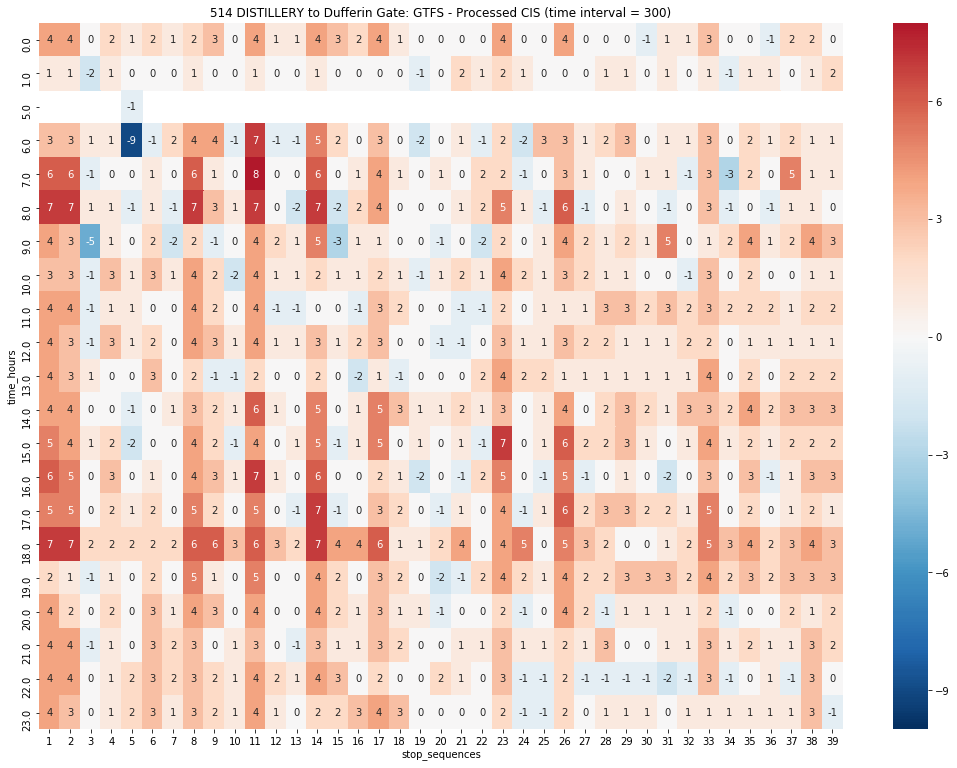

In [14]:
df_300_d1 = df_300[df_300['direction_ids']==1]

df_300_d1 = df_300_d1.pivot("time_hours", "stop_sequences", "diff")

plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('514 DISTILLERY to Dufferin Gate: GTFS - Processed CIS (time interval = 300)')
sns.heatmap(df_300_d1, vmin=-10, vmax=8, cmap = 'RdBu_r', center=0, annot=True, fmt='g')

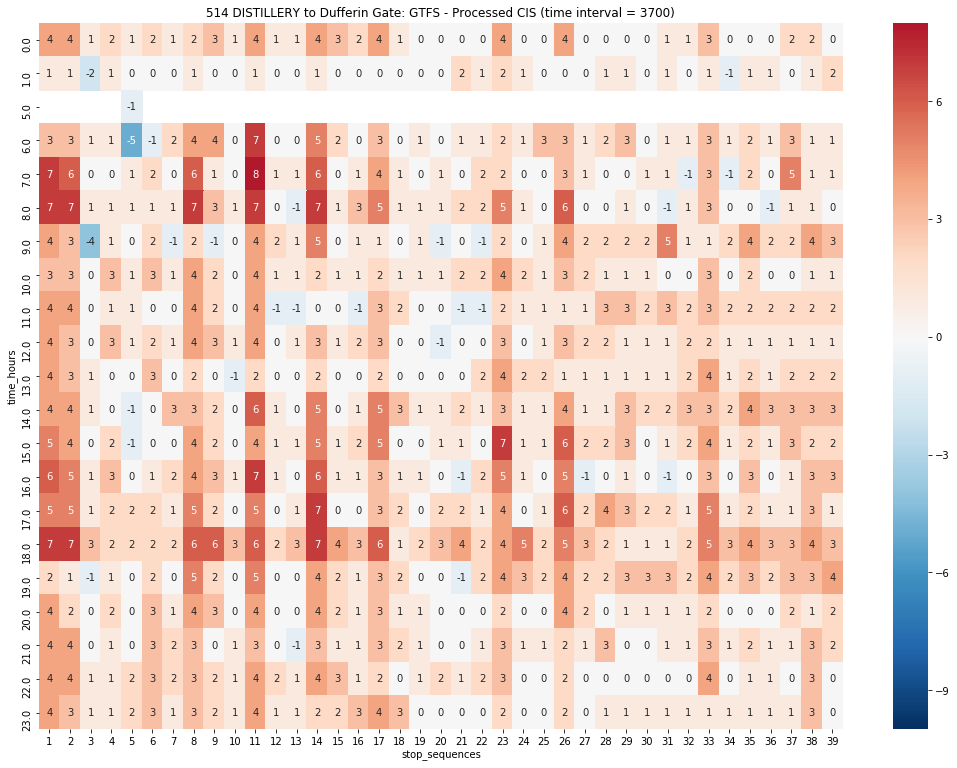

In [15]:
df_3700_d1 = df_3700[df_3700['direction_ids']==1]

df_3700_d1 = df_3700_d1.pivot("time_hours", "stop_sequences", "diff")

plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('514 DISTILLERY to Dufferin Gate: GTFS - Processed CIS (time interval = 3700)')
sns.heatmap(df_3700_d1, vmin=-10, vmax=8, cmap = 'RdBu_r', center=0, annot=True, fmt='g')

** Comparing the heat maps which have the same direction but different time intervals, the heat map with time interval as 300 has the extreme number at stop sequences as 3 and 5, while the heat map with time interval as 3700 has more moderate values at stop sequences as 3 and 5.  **

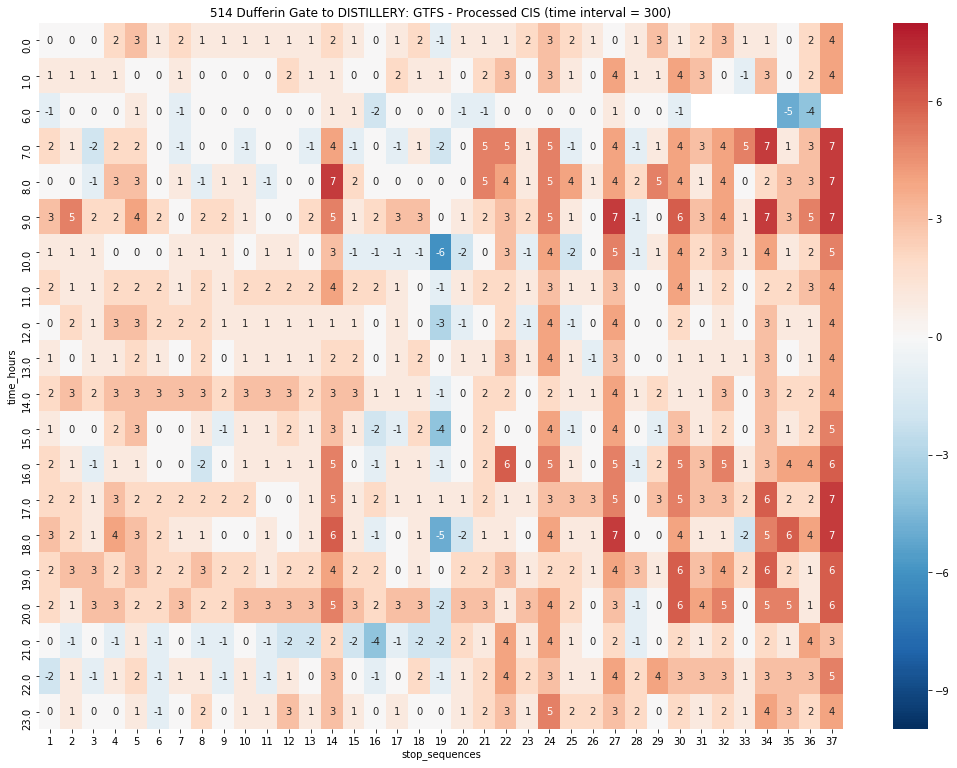

In [16]:
df_300_d0 = df_300[df_300['direction_ids']==0]

df_300_d0 = df_300_d0.pivot("time_hours", "stop_sequences", "diff")

plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('514 Dufferin Gate to DISTILLERY: GTFS - Processed CIS (time interval = 300)')
sns.heatmap(df_300_d0, vmin=-10, vmax=8, cmap = 'RdBu_r', center=0, annot=True, fmt='g')

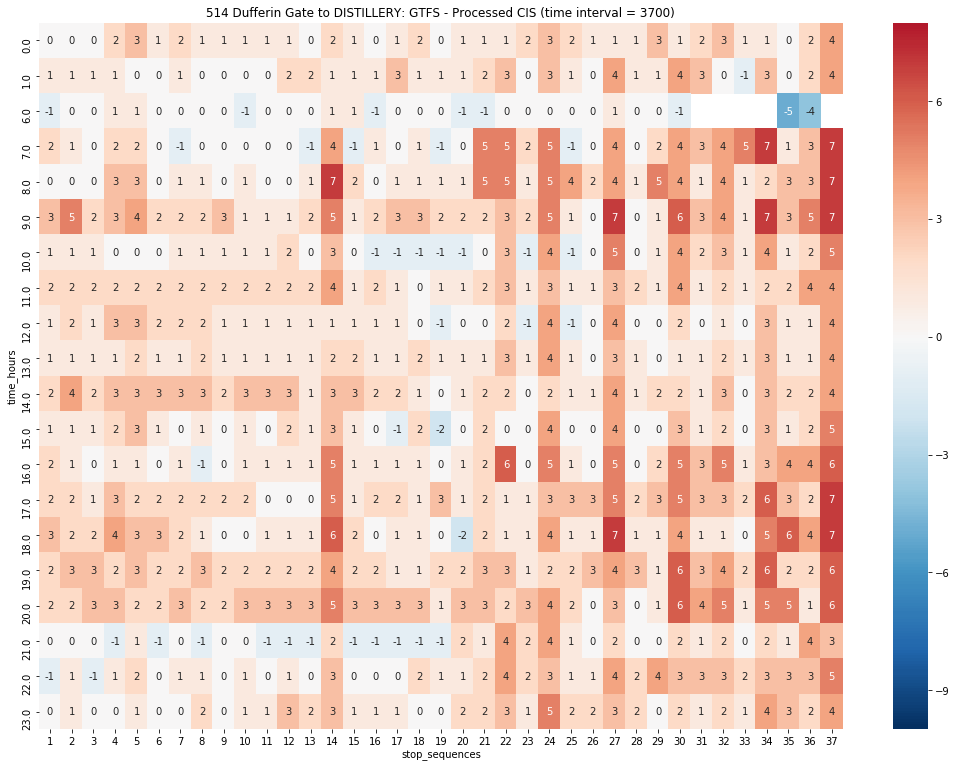

In [17]:
df_3700_d0 = df_3700[df_3700['direction_ids']==0]

df_3700_d0 = df_3700_d0.pivot("time_hours", "stop_sequences", "diff")

plt.figure(figsize = (18,13))
ax = plt.axes()
ax.set_title('514 Dufferin Gate to DISTILLERY: GTFS - Processed CIS (time interval = 3700)')
sns.heatmap(df_3700_d0, vmin=-10, vmax=8, cmap = 'RdBu_r', center=0, annot=True, fmt='g')

** Comparing the heat maps which have the same direction but different time intervals, the heat map with time interval as 300 has the extreme number at stop sequences as 19, while the heat map with time interval as 3700 has more moderate values at stop sequences as 19. Also, both heat maps have their extreme high different values at 6 A.M. at stop sequence 35 and 36. **

** Thus, there are two sets of heat maps illustrate that time interval as 3700 is more suitable than time interval as 300. **

To explore the reason of extreme high different values (dark blue cells) at 9 A.M. with stop sequence of 3 and at 6 A.M. with stop sequence of 5 (heat maps with direction_id = 1), comparing the CIS table with their time intervals as 300 and 3700 can help to define the importances of time interval and the impacts to extreme values.

In [22]:
# Find the stop IDs which equal to stop sequence of 3 and 5.

sql_stop_sequence = '''
SELECT DISTINCT ON(stop_id, stop_sequence) stop_id, stop_sequence, stop_name, direction_id, shape_id
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
INNER JOIN gtfs_raph.stops_20171004 USING (stop_id)
WHERE route_short_name = '514' AND shape_id IN (691040, 691042) AND stop_sequence IN (3, 5) AND direction_id = 1
'''

print_table(sql_stop_sequence, con)

stop_id,stop_sequence,stop_name,direction_id,shape_id
7621,5,KING ST EAST AT SACKVILLE ST,1,691042
15354,3,CHERRY ST AT FRONT ST EAST,1,691042


In [123]:
# Using the corresponding stop IDs to find the CIS data with the stop IDs and the hours 
# under the condition of time interval = 300.

compare_300 = '''
WITH line_data AS(
SELECT geom AS line, direction_id FROM gtfs_raph.shapes_geom_20171004
    INNER JOIN gtfs_raph.trips_20171004 USING (shape_id)
    WHERE shape_id IN (691040, 691042)
    GROUP BY line, shape_id, direction_id
    ORDER BY shape_id
),

cis_gtfs AS(
SELECT date_time, id AS cis_id, stop_id, a.direction_id,
ST_LineLocatePoint(line, position) AS cis_to_line, vehicle,
ST_LineLocatePoint(line, geom) AS stop_to_line,
(CASE WHEN ST_LineLocatePoint(line, position) > ST_LineLocatePoint(line, geom)
      THEN 'after'
      WHEN ST_LineLocatePoint(line, position) < ST_LineLocatePoint(line, geom)
      THEN 'before'
      WHEN ST_LineLocatePoint(line, position) = ST_LineLocatePoint(line, geom)
      THEN 'same'
      END) AS line_position,
ST_Distance(position::geography, geom::geography) AS distance
FROM line_data a, dzou2.dd_cis_514_angle b
INNER JOIN gtfs_raph.stops_20171004 USING (stop_id)
WHERE a.direction_id = b.direction_id
ORDER BY direction_id, date_time),

match_stop_300 AS(
SELECT EXTRACT(HOUR FROM MIN(date_time)) AS hours, MIN(date_time) AS arrival_time, MAX(date_time) AS departure_time, vehicle, stop_id, direction_id, array_agg(cis_id) AS cis_group
FROM cis_gtfs
WHERE (stop_id IN (7621, 15354)) AND direction_id = 1 AND
      ((line_position = 'before' AND distance <= 200) OR (line_position = 'after' AND distance <= 10)
      OR (line_position = 'same' AND distance <= 100))
GROUP BY vehicle, stop_id, direction_id, (floor((extract('epoch' from date_time)-1) / 300) * 300)
ORDER BY arrival_time, direction_id
),

new_stop_times AS (
SELECT DISTINCT ON(stop_id, stop_sequence) stop_id, stop_sequence, direction_id, shape_id
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND shape_id IN (691040, 691042)
)

SELECT hours, arrival_time, departure_time, vehicle, stop_id, cis_group 
FROM match_stop_300
WHERE (hours = 9 AND stop_id = 15354) OR (hours = 6 AND stop_id = 7621) 
'''

print_table(compare_300, con)

hours,arrival_time,departure_time,vehicle,stop_id,cis_group
6.0,2017-10-04 06:00:20,2017-10-04 06:00:20,4442,7621,[44]
6.0,2017-10-04 06:07:00,2017-10-04 06:07:20,4403,7621,"[3039, 3040]"
6.0,2017-10-04 06:10:00,2017-10-04 06:10:00,4425,7621,[5756]
6.0,2017-10-04 06:10:40,2017-10-04 06:11:00,4425,7621,"[5758, 5759]"
6.0,2017-10-04 06:13:20,2017-10-04 06:13:20,4419,7621,[10444]
6.0,2017-10-04 06:19:00,2017-10-04 06:19:40,4409,7621,"[8757, 8758, 8756]"
6.0,2017-10-04 06:22:20,2017-10-04 06:22:20,4419,7621,[10469]
6.0,2017-10-04 06:34:40,2017-10-04 06:35:00,4413,7621,"[13098, 13097]"
6.0,2017-10-04 06:35:20,2017-10-04 06:35:40,4413,7621,"[13100, 13099]"
6.0,2017-10-04 06:38:40,2017-10-04 06:39:20,4404,7621,"[14531, 14530, 14532]"


As the table shown, when stop_id is 7621 (KING ST EAST AT SACKVILLE ST) and hour is 6, there are several pairs of data which have the same vehicle and stop_id and close time. 

For example,


|hours|arrival_time|departure_time|vehicle|stop_id|cis_group|
|--|--|--|--|--|--|
|6.0|2017-10-04 06:10:00|2017-10-04 06:10:00|4425|7621|[5756]|
|6.0|2017-10-04 06:10:40|2017-10-04 06:11:00|4425|7621|[5758, 5759]|

and

|hours|arrival_time|departure_time|vehicle|stop_id|cis_group|
|--|--|--|--|--|--|
|6.0|2017-10-04 06:34:40|2017-10-04 06:35:00|4413|7621|[13098, 13097]|
|6.0|2017-10-04 06:35:20|2017-10-04 06:35:40|4413|7621|[13100, 13099]|

It is obvious that they have the same vehicle and stop_id, and their cis_id and time are close. So, they should be grouped together. However, they are separated becasue time interval is 5 minutes and they are cut at 2017-10-04 06:10:00 and 2017-10-04 06:35:00 in the examples. 


The same issues exist under the condition of stop is 15354 (CHERRY ST AT FRONT ST EAST) and hour is 9.


|hours|arrival_time|departure_time|vehicle|stop_id|cis_group|
|--|--|--|--|--|--|
|9.0|2017-10-04 09:25:00|2017-10-04 09:25:00|4416|15354|[17806]|
|9.0|2017-10-04 09:25:20|2017-10-04 09:25:20|4416|15354|[17807]|

In [124]:
# Let's see if 3700 as time interval can improve the situation.

compare_3700 = '''
WITH line_data AS(
SELECT geom AS line, direction_id FROM gtfs_raph.shapes_geom_20171004
    INNER JOIN gtfs_raph.trips_20171004 USING (shape_id)
    WHERE shape_id IN (691040, 691042)
    GROUP BY line, shape_id, direction_id
    ORDER BY shape_id
),

cis_gtfs AS(
SELECT date_time, id AS cis_id, stop_id, a.direction_id,
ST_LineLocatePoint(line, position) AS cis_to_line, vehicle,
ST_LineLocatePoint(line, geom) AS stop_to_line,
(CASE WHEN ST_LineLocatePoint(line, position) > ST_LineLocatePoint(line, geom)
      THEN 'after'
      WHEN ST_LineLocatePoint(line, position) < ST_LineLocatePoint(line, geom)
      THEN 'before'
      WHEN ST_LineLocatePoint(line, position) = ST_LineLocatePoint(line, geom)
      THEN 'same'
      END) AS line_position,
ST_Distance(position::geography, geom::geography) AS distance
FROM line_data a, dzou2.dd_cis_514_angle b
INNER JOIN gtfs_raph.stops_20171004 USING (stop_id)
WHERE a.direction_id = b.direction_id
ORDER BY direction_id, date_time),

match_stop_300 AS(
SELECT EXTRACT(HOUR FROM MIN(date_time)) AS hours, MIN(date_time) AS arrival_time, MAX(date_time) AS departure_time, vehicle, stop_id, direction_id, array_agg(cis_id) AS cis_group
FROM cis_gtfs
WHERE (stop_id IN (7621, 15354)) AND direction_id = 1 AND
      ((line_position = 'before' AND distance <= 200) OR (line_position = 'after' AND distance <= 10)
      OR (line_position = 'same' AND distance <= 100))
GROUP BY vehicle, stop_id, direction_id, (floor((extract('epoch' from date_time)-1) / 3700) * 3700)
ORDER BY arrival_time, direction_id
),

new_stop_times AS (
SELECT DISTINCT ON(stop_id, stop_sequence) stop_id, stop_sequence, direction_id, shape_id
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '514' AND shape_id IN (691040, 691042)
)

SELECT hours, arrival_time, departure_time, vehicle, stop_id, cis_group 
FROM match_stop_300
WHERE (hours = 9 AND stop_id = 15354) OR (hours = 6 AND stop_id = 7621) 
'''

print_table(compare_3700, con)

hours,arrival_time,departure_time,vehicle,stop_id,cis_group
6.0,2017-10-04 06:07:00,2017-10-04 06:07:20,4403,7621,"[3040, 3039]"
6.0,2017-10-04 06:10:00,2017-10-04 06:11:00,4425,7621,"[5759, 5756, 5758]"
6.0,2017-10-04 06:13:20,2017-10-04 06:22:20,4419,7621,"[10469, 10444]"
6.0,2017-10-04 06:19:00,2017-10-04 06:19:40,4409,7621,"[8758, 8757, 8756]"
6.0,2017-10-04 06:34:40,2017-10-04 06:35:40,4413,7621,"[13100, 13098, 13097, 13099]"
6.0,2017-10-04 06:38:40,2017-10-04 06:39:20,4404,7621,"[14532, 14530, 14531]"
6.0,2017-10-04 06:49:00,2017-10-04 06:49:40,4416,7621,"[17369, 17370, 17371]"
6.0,2017-10-04 06:54:00,2017-10-04 07:10:40,4438,7621,"[223, 21136]"
6.0,2017-10-04 06:54:40,2017-10-04 06:54:40,4418,7621,[18240]
9.0,2017-10-04 09:00:20,2017-10-04 09:00:40,4419,15354,"[10908, 10907]"


When the time interval changes to 3700, it extends the time period to separate the CIS groups.

Comparing the examples from `time interval = 300` and from `time_interval = 3700` at  stop "KING ST EAST AT SACKVILLE ST" (stop id 7621),

time interval = 300:

|hours|arrival_time|departure_time|vehicle|stop_id|cis_group|
|--|--|--|--|--|--|
|6.0|2017-10-04 06:10:00|2017-10-04 06:10:00|4425|7621|[5756]|
|6.0|2017-10-04 06:10:40|2017-10-04 06:11:00|4425|7621|[5758, 5759]|

time interval = 3700:

|hours|arrival_time|departure_time|vehicle|stop_id|cis_group|
|--|--|--|--|--|--|
|6.0|2017-10-04 06:10:00|2017-10-04 06:11:00|4425|7621|[5759, 5756, 5758]|

and when

time interval = 300:

|hours|arrival_time|departure_time|vehicle|stop_id|cis_group|
|--|--|--|--|--|--|
|6.0|2017-10-04 06:34:40|2017-10-04 06:35:00|4413|7621|[13098, 13097]|
|6.0|2017-10-04 06:35:20|2017-10-04 06:35:40|4413|7621|[13100, 13099]|

time interval = 3700:

|hours|arrival_time|departure_time|vehicle|stop_id|cis_group|
|--|--|--|--|--|--|
|6.0|2017-10-04 06:34:40|2017-10-04 06:35:40|4413|7621|[13100, 13098, 13097, 13099]|

For stop id is 15354 (CHERRY ST AT FRONT ST EAST) and hour is 9,

time interval = 300:

|hours|arrival_time|departure_time|vehicle|stop_id|cis_group|
|--|--|--|--|--|--|
|9.0|2017-10-04 09:25:00|2017-10-04 09:25:00|4416|15354|[17806]|
|9.0|2017-10-04 09:25:20|2017-10-04 09:25:20|4416|15354|[17807]|

time interval = 3700:

|hours|arrival_time|departure_time|vehicle|stop_id|cis_group|
|--|--|--|--|--|--|
|9.0|2017-10-04 09:25:00|2017-10-04 09:25:20|4416|15354|[17807, 17806]|


**Since 3700 as time interval can help to group the CIS data together, choosing 3700 is better than 300 as time interval.**

### The heat maps of Route 504 with time interval as 3700 

In [18]:
sql_3700_504 = '''
WITH 
gtfs_data AS (
SELECT (CASE WHEN EXTRACT(HOUR FROM arrival_time)<= 23
         THEN EXTRACT(HOUR FROM arrival_time)
         WHEN EXTRACT(HOUR FROM arrival_time) = 24
         THEN 0
         WHEN EXTRACT(HOUR FROM arrival_time) = 25
         THEN 1
         END) AS hours,
         stop_id, count(*) AS GTFS_count, direction_id
FROM gtfs_raph.stop_times_20171004_504_514 
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '504'
GROUP BY hours, stop_id, direction_id
ORDER BY hours
),

cis_data AS (
SELECT EXTRACT(HOUR FROM arrival_time) as hours, stop_id, count(*) AS cis_count, direction_id
FROM match_stop_504
GROUP BY hours, stop_id, direction_id
ORDER BY hours
),

new_stop_times AS (
SELECT DISTINCT ON(stop_id, stop_sequence) stop_id, stop_sequence, direction_id, shape_id
FROM gtfs_raph.stop_times_20171004_504_514
INNER JOIN gtfs_raph.trips_20171004 USING (trip_id)
WHERE route_short_name = '504' AND shape_id IN (690863, 690880)
),

new_cis_data AS (
SELECT hours, stop_sequence, sum(cis_count) AS cis_count, d.direction_id
FROM cis_data d
INNER JOIN new_stop_times USING (stop_id, direction_id)
GROUP BY hours, stop_sequence, d.direction_id
),

new_gtfs_data AS (
SELECT hours, stop_sequence, sum(GTFS_count) AS gtfs_count, e.direction_id
FROM gtfs_data e
INNER JOIN new_stop_times USING (stop_id, direction_id)
GROUP BY hours, stop_sequence, e.direction_id
)

SELECT COALESCE(a.hours, b.hours)AS time_hours, COALESCE(a.stop_sequence, b.stop_sequence) AS stop_sequences,
COALESCE(a.direction_id, b.direction_id) AS direction_ids,
(CASE WHEN gtfs_count IS NULL THEN 0 ELSE gtfs_count END) - (CASE WHEN cis_count IS NULL THEN 0 ELSE cis_count END) AS diff
FROM new_gtfs_data a 
FULL JOIN new_cis_data b ON (a.hours = b.hours) AND (a.stop_sequence = b.stop_sequence) AND (a.direction_id = b.direction_id)
GROUP BY time_hours, stop_sequences, gtfs_count, cis_count, diff, direction_ids
ORDER BY time_hours, stop_sequences, direction_ids
'''

df_514 = pandasql.read_sql(sql_3700_504, con)

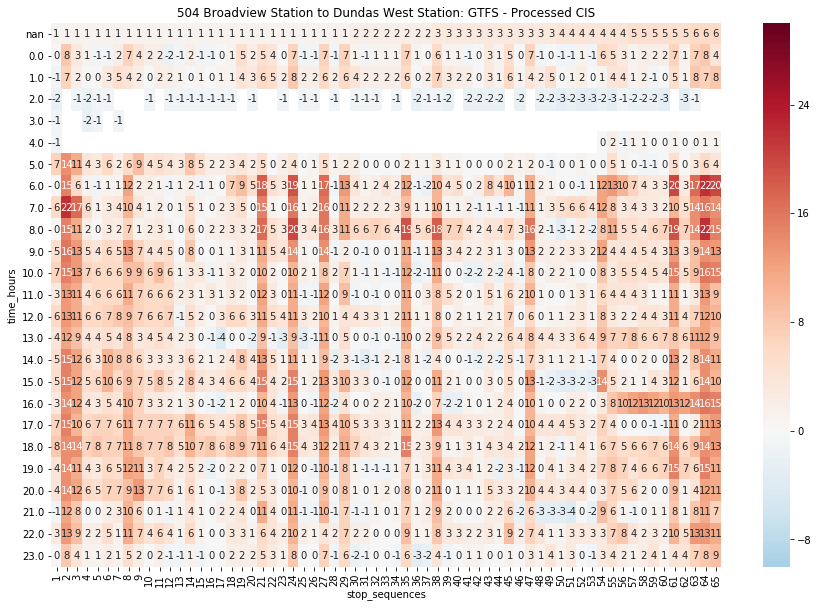

In [19]:
df_514_d1 = df_514[df_514['direction_ids']==1]

df_514_d1 = df_514_d1.pivot("time_hours", "stop_sequences", "diff")

plt.figure(figsize = (15,10))
ax = plt.axes()
ax.set_title('504 Broadview Station to Dundas West Station: GTFS - Processed CIS')
sns.heatmap(df_514_d1, vmin=-10, vmax=30, cmap = 'RdBu_r', center=0, annot=True, fmt='g')

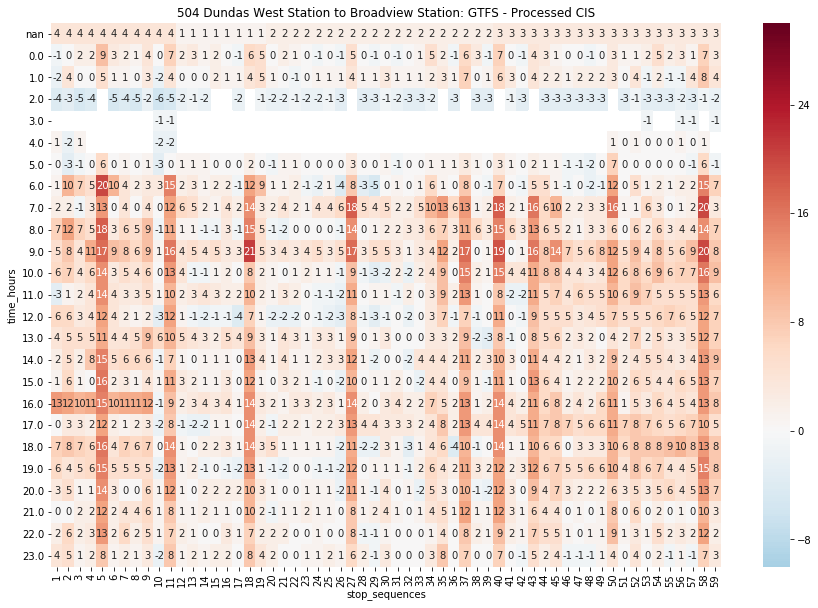

In [20]:
df_514_d0 = df_514[df_514['direction_ids']==0]

df_514_d0 = df_514_d0.pivot("time_hours", "stop_sequences", "diff")

plt.figure(figsize = (15,10))
ax = plt.axes()
ax.set_title('504 Dundas West Station to Broadview Station: GTFS - Processed CIS')
sns.heatmap(df_514_d0, vmin=-10, vmax=30, cmap = 'RdBu_r', center=0, annot=True, fmt='g')

### Assign Trip IDs to CIS data 

Dorothy only assigns the trip IDs for the CIS data of **route 514 on 10/04/2017** which have more than 10 CIS position records in one trip. There are some CIS data records change their directions abnormally, and some CIS data change their closest stops frequently in the terminal areas because of the unstability of GPS. The abnormal points create short trips as the table shown below, and filtering out the short trips can help to assign the trip IDs to the more reliable CIS data.

In [71]:
sql_count = '''
SELECT nextval('cis_lst_test')
'''

sql_trip_id_514 = '''
WITH
order_data AS (
SELECT arrival_time, departure_time, vehicle, stop_id, direction_id, cis_id,
rank() OVER (PARTITION BY vehicle ORDER BY arrival_time) AS order_id
FROM match_stop_514
ORDER BY vehicle, arrival_time
),

trips AS(
SELECT
(CASE WHEN lag(vehicle, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time) IS NULL
      THEN nextval('cis_lst')
      WHEN (direction_id <> lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN nextval('cis_lst')
      WHEN (direction_id = lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN currval('cis_lst')
END) AS trip_id,
arrival_time, departure_time, cis_id, direction_id, vehicle, stop_id
FROM order_data
ORDER BY vehicle, arrival_time
),

open_array AS (
SELECT trip_id, arrival_time, departure_time, unnest(cis_id) AS cis_id, direction_id, vehicle, stop_id
FROM trips
ORDER BY vehicle, arrival_time
)

SELECT count(*) AS cnt
FROM open_array
GROUP BY trip_id
'''
cis_list_count = pandasql.read_sql(sql_count, con)
trip_group_514 = pandasql.read_sql(sql_trip_id_514, con)

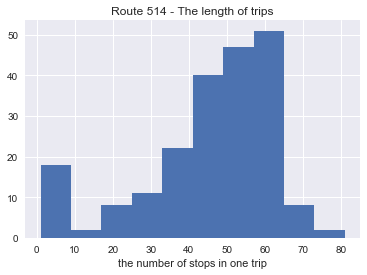

In [72]:
trip_group_514.hist()
plt.xlabel('the number of stops in one trip')
plt.title('Route 514 - The length of trips')

As the table shown, the longest trip has 80+ CIS data records, and the shorter trips have 20+ data records. However, there are multiple trips have 1-9 data records which may be the trips with errors, and there are few trips with has the number of data records between 9 and 20. The fracture seems like the indicator, and the trips with less than 10 data records are too short, so the trips with less than 10 data records will be filtered out.

For **route 504 on 10/04/2017**, Here is the table shows its trip IDs and the number of CIS data records. 

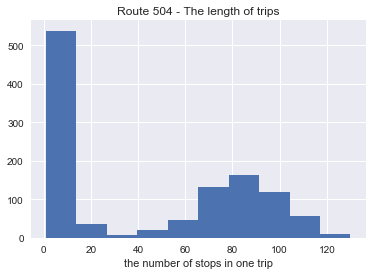

In [74]:
sql_count = '''
SELECT nextval('cis_lst_test')
'''

sql_trip_id_504 = '''
WITH
order_data AS (
SELECT arrival_time, departure_time, vehicle, stop_id, direction_id, cis_id,
rank() OVER (PARTITION BY vehicle ORDER BY arrival_time) AS order_id
FROM match_stop_504
ORDER BY vehicle, arrival_time
),

trips AS(
SELECT
(CASE WHEN lag(vehicle, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time) IS NULL
      THEN nextval('cis_lst')
      WHEN (direction_id <> lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN nextval('cis_lst')
      WHEN (direction_id = lag(direction_id, 1) OVER (PARTITION BY vehicle ORDER BY arrival_time))
      THEN currval('cis_lst')
END) AS trip_id,
arrival_time, departure_time, cis_id, direction_id, vehicle, stop_id
FROM order_data
ORDER BY vehicle, arrival_time
),

open_array AS (
SELECT trip_id, arrival_time, departure_time, unnest(cis_id) AS cis_id, direction_id, vehicle, stop_id
FROM trips
ORDER BY vehicle, arrival_time
)

SELECT count(*) AS cnt
FROM open_array
GROUP BY trip_id
'''
cis_list_count = pandasql.read_sql(sql_count, con)
trip_group_504 = pandasql.read_sql(sql_trip_id_504, con)

trip_group_504.hist()
plt.xlabel('the number of stops in one trip')
plt.title('Route 504 - The length of trips')

Since it has multiple shapes, and some of the shapes are very short, the number of filter indicator will based on the number of stops of the shortest shapes. 

In [81]:
sql_504_shapes = '''
SELECT shape_id, count(*) FROM dd_504_stop_pattern
GROUP BY shape_id
ORDER BY count(*)
'''

print_table(sql_504_shapes, con)

shape_id,count
690864,10
690866,11
690882,12
690881,14
690867,50
690873,53
690860,58
690859,59
690863,59
690880,65


The number of stops of the shortest shape for route 504 is 10, so each trip should have at least 10 data records.

(The reason why not using this method for route 514 is that the number of stops of shortest shape in route 514 is 30, which will filtered out too many trips if the number is the filter indicator; also, the trips of route 514 have the obvious fracture, while the trips of route 504 do not.)

In [82]:
sql_514_shapes = '''
SELECT shape_id, count(*) FROM dd_514_stop_pattern
GROUP BY shape_id
ORDER BY count(*)
'''

print_table(sql_514_shapes, con)

shape_id,count
691041,30
691043,33
691040,37
691042,39


In [83]:
con.close()